# Notebook 3 : Création d'un score métier et modélisation


## Contexte
Ce notebook fait suite au travail d'exploration des données et de feature engineering réalisé précédemment. Nous allons maintenant nous concentrer sur la création d'un score métier adapté au contexte du crédit à la consommation et sur l'expérimentation de différents modèles.

 
## Objectifs
- Définir un score métier qui tient compte du déséquilibre du coût entre faux positifs et faux négatifs
- Mettre en place une stratégie d'évaluation (validation croisée)
- Tester plusieurs modèles et les comparer
- Optimiser les hyperparamètres du meilleur modèle
- Analyser l'importance des features (globales et locales)


## Rappel des spécifications du manager
- Le déséquilibre entre les classes doit être pris en compte
- Le coût d'un faux négatif (FN - mauvais client prédit bon client) est supposé 10 fois supérieur au coût d'un faux positif (FP - bon client prédit mauvais)
- Nous devons créer un score "métier" (minimisation du coût d'erreur de prédiction) pour comparer les modèles
- L'optimisation du seuil de probabilité est nécessaire (le seuil par défaut de 0.5 n'est pas forcément optimal)


# Imports et configurations

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer,confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import mlflow
import mlflow.sklearn

# Configuration globale
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

# Ajouter les chemins du projet
notebook_dir = Path().absolute()
project_dir = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.append(str(project_dir))

data_analysis_dir = project_dir / 'data' / 'analysis'
visualizations_dir = project_dir / 'visualizations'
reports_dir = project_dir / 'reports'

In [2]:
# Configuration MLflow
import mlflow
import mlflow.sklearn
from datetime import datetime

# Fermer tout run actif (si un ancien run est encore ouvert)
while mlflow.active_run():
    run_info = mlflow.active_run().info
    print(f" Fermeture du run précédent: {run_info.run_name} (id: {run_info.run_id})")
    mlflow.end_run()

# Définir l'URI de tracking MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Nom de l'expérience
experiment_name = "3-credit-scoring-model-training"
mlflow.set_experiment(experiment_name)

# Démarrer un run MLflow manuellement
mlflow_run = mlflow.start_run(run_name="data_credit-scoring-model-training")

# Vérification
print(f" MLflow - Expérience: {experiment_name}")
print(f" Run démarré: {mlflow_run.info.run_name} (id: {mlflow_run.info.run_id})")

# Timer pour mesurer les performances
from contextlib import contextmanager

 MLflow - Expérience: 3-credit-scoring-model-training
 Run démarré: data_credit-scoring-model-training (id: 4efae50444ff4dc5ba5534aaa6ae1f06)


#  Chargement des données

In [3]:
from sklearn.model_selection import train_test_split

# Chargement des fichiers preprocessés
train_df = pd.read_csv('../data/processed/train_preprocessed.csv', index_col=0)
test_df = pd.read_csv('../data/processed/test_preprocessed.csv', index_col=0)

# Préparation train/validation
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Données chargées - Train: {X_train.shape}, Val: {X_val.shape}, Test: {test_df.shape}")
print(f" Taux de défaut: {y.mean()*100:.1f}%")

 Données chargées - Train: (246005, 234), Val: (61502, 234), Test: (48744, 234)
 Taux de défaut: 8.1%


# Fonctions

In [4]:
# Classe pour le scoring métier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class BusinessScorer:
    def __init__(self, fn_cost=10, fp_cost=1):
        self.fn_cost = fn_cost  # Coût faux négatif (mauvais client prédit bon client)
        self.fp_cost = fp_cost  # Coût faux positif (bon client prédit mauvais client)
    
    def calculate_metrics(self, y_true, y_pred_proba, threshold=0.5):
        """Calcule toutes les métriques pour un seuil donné
        
        Cette fonction centralise le calcul des métriques techniques ET business
        permettant une évaluation complète du modèle selon les deux perspectives
        
        Args:
            y_true: Labels réels (0=bon client, 1=mauvais client)
            y_pred_proba: Probabilités prédites pour la classe positive (défaut)
            threshold: Seuil de décision (défaut=0.5)
            
        Returns:
            dict: Dictionnaire complet des métriques techniques et business
        """
        # Conversion probabilités -> prédictions binaires
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Matrice de confusion : base de tous les calculs
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Métriques
        # Coûts réels selon la matrice de coûts définie (cahier des charges)
        total_cost = (fn * self.fn_cost) + (fp * self.fp_cost)  # FN=10x plus coûteux
        
        # Coût moyen par client (métrique principale à minimiser)
        avg_cost = total_cost / len(y_true)
        
        # Taux de refus = % de demandes refusées (impact sur le volume d'affaires)
        refusal_rate = y_pred.mean()
        
        return {
            # Paramètres de la prédiction
            'threshold': threshold,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,  # Éléments de la matrice de confusion
            'total_cost': total_cost,     # Coût total sur l'échantillon
            'avg_cost': avg_cost,         # Coût moyen par client (À MINIMISER)
            'refusal_rate': refusal_rate, # % de demandes refusées
            'accuracy': accuracy_score(y_true, y_pred),  # % prédictions correctes
            'precision': precision_score(y_true, y_pred, zero_division=0),  # Fiabilité des alertes
            'recall': recall_score(y_true, y_pred, zero_division=0),        # Capacité de détection
            'f1_score': f1_score(y_true, y_pred, zero_division=0),          # Équilibre précision/rappel
            'auc': roc_auc_score(y_true, y_pred_proba)  # Performance discriminative
        }
    
    def find_optimal_threshold(self, y_true, y_pred_proba):
        """Trouve le seuil optimal qui minimise le coût moyen
        
        Approche conforme au cahier des charges : minimiser les coûts métier
        en tenant compte du ratio FN/FP = 10:1.
        
        Args:
            y_true: Labels réels (0/1)
            y_pred_proba: Probabilités prédites pour la classe positive
            
        Returns:
            tuple: (seuil_optimal, dictionnaire_métriques_complètes)
        """
        thresholds = np.linspace(0.01, 0.99, 100)
        costs = []
        
        # Évaluation de chaque seuil candidat
        for threshold in thresholds:
            metrics = self.calculate_metrics(y_true, y_pred_proba, threshold)
            costs.append(metrics['avg_cost'])
        
        # Sélection du seuil optimal (coût minimum)
        optimal_idx = np.argmin(costs)
        optimal_threshold = thresholds[optimal_idx]
        
        return optimal_threshold, self.calculate_metrics(y_true, y_pred_proba, optimal_threshold)
    
    def cross_validate(self, model, X, y, cv=5):
        """Validation croisée avec optimisation du score métier
        
        Contrairement à la validation croisée classique, chaque fold optimise
        son propre seuil selon le coût minimum, donnant une estimation plus
        réaliste des performances en production.
        
        Args:
            model: Modèle scikit-learn avec predict_proba
            X, y: Données d'entraînement
            cv: Nombre de folds
            
        Returns:
            DataFrame: Résultats pour chaque fold avec seuil optimisé
        """
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_results = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            # Split stratifié pour préserver la distribution des classes
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Entraînement sur le fold
            model.fit(X_train_fold, y_train_fold)
            y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
            
            # Optimisation coût minimum spécifique au fold
            optimal_threshold, metrics = self.find_optimal_threshold(y_val_fold, y_pred_proba)
            metrics['fold'] = fold + 1
            cv_results.append(metrics)
        
        return pd.DataFrame(cv_results)

# Initialiser le scorer conforme au cahier des charges
scorer = BusinessScorer(fn_cost=10, fp_cost=1)
print("BusinessScorer ok (FN coût: 10x, FP coût: 1x selon cahier des charges)")

BusinessScorer ok (FN coût: 10x, FP coût: 1x selon cahier des charges)


In [5]:
# Classe wrapper universelle pour tous les modèles
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class UniversalModelWrapper:
    def __init__(self, model_type='lightgbm', resampling=None, **model_params):
        """
        Wrapper universel pour tous les modèles avec preprocessing optionnel
        
        Args:
            model_type: 'lightgbm', 'logistic', 'randomforest'
            resampling: None, 'smote', 'undersample', 'class_weight'
            **model_params: paramètres spécifiques au modèle
        """
        self.model_type = model_type
        self.resampling = resampling
        self.imputer = SimpleImputer(strategy='median')
        self.need_imputation = (resampling in ['smote', 'undersample']) or (model_type in ['logistic', 'randomforest'])
        
        # Initialiser le modèle selon le type
        default_params = {
            'lightgbm': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 8, 'random_state': 42},
            'logistic': {'max_iter': 1000, 'solver': 'liblinear', 'random_state': 42},
            'randomforest': {'n_estimators': 100, 'max_depth': 10, 'random_state': 42}
        }
        
        params = {**default_params[model_type], **model_params}
        
        # Ajouter class_weight si demandé
        if resampling == 'class_weight':
            params['class_weight'] = 'balanced'
        
        if model_type == 'lightgbm':
            self.model = lgb.LGBMClassifier(**params)
        elif model_type == 'logistic':
            self.model = LogisticRegression(**params)
        elif model_type == 'randomforest':
            self.model = RandomForestClassifier(**params)
        
        # Initialiser le resampler si nécessaire
        if resampling == 'smote':
            self.resampler = SMOTE(random_state=42)
        elif resampling == 'undersample':
            self.resampler = RandomUnderSampler(random_state=42)
        else:
            self.resampler = None
    
    def fit(self, X, y):
        # Imputation si nécessaire
        X_processed = self.imputer.fit_transform(X) if self.need_imputation else X
        
        # Rééchantillonnage si nécessaire
        if self.resampler:
            X_processed, y = self.resampler.fit_resample(X_processed, y)
            if self.resampling == 'undersample':
                print(f"Rééchantillonnage: {len(y)} échantillons")
        
        # Entraînement
        self.model.fit(X_processed, y)
        return self
    
    def predict_proba(self, X):
        # Même logique que fit()
        X_processed = self.imputer.transform(X) if self.need_imputation else X
        return self.model.predict_proba(X_processed)
    
    def get_params(self):
        return {
            'model_type': self.model_type,
            'resampling': self.resampling,
            **self.model.get_params()
        }

print("UniversalModelWrapper ok")

UniversalModelWrapper ok


In [6]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(models_dict, X_val, y_val, title="Comparaison des courbes ROC"):
    """
    Plot courbes ROC pour plusieurs modèles
    
    Args:
        models_dict: {model_name: model_object}
        X_val, y_val: données de validation
        title: titre du graphique
    """
    plt.figure(figsize=(10, 8))
    
    for name, model in models_dict.items():
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        auc_score = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2,
                 label=f'{name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Tracking
    filename = f'courbes_roc_{title.lower().replace(" ", "_")}.png'
    filepath = visualizations_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(str(filepath))
    plt.show()
    
    # Cleanup
    if os.path.exists(filename):
        os.remove(filename)

def run_experiment_phase(strategies, phase_name):
    """Fonction réutilisable pour exécuter une phase d'expérimentation"""
    results_summary = []
    trained_models = {}
    
    for strategy_key, config in strategies.items():
        run_name = f"{phase_name}_{config['model_type']}_{config['resampling'] or 'baseline'}"
        # Fermer le run principal temporairement
        if mlflow.active_run():
            mlflow.end_run()
        
        with mlflow.start_run(run_name=strategy_key):
            # Créer le modèle
            if config['model_type'] == 'dummy':
                from sklearn.dummy import DummyClassifier
                model = DummyClassifier(strategy='stratified', random_state=42)
            else:
                model = UniversalModelWrapper(
                    model_type=config['model_type'],
                    resampling=config['resampling']
                )
            
            # Entraînement
            model.fit(X_train, y_train)
            trained_models[config['name']] = model
            
            # Prédictions
            y_val_proba = model.predict_proba(X_val)[:, 1]
            
            # Calcul des métriques
            optimal_threshold, metrics = scorer.find_optimal_threshold(y_val, y_val_proba)
            
            # Logging MLflow
            mlflow.log_param("strategy", config['name'])
            mlflow.log_param("model_type", config['model_type'])
            mlflow.log_param("resampling", config['resampling'])
            mlflow.log_param("phase", phase_name)
            
            mlflow.log_metric("auc", metrics['auc'])
            mlflow.log_metric("accuracy", metrics['accuracy'])
            mlflow.log_metric("precision", metrics['precision'])
            mlflow.log_metric("recall", metrics['recall'])
            mlflow.log_metric("f1_score", metrics['f1_score'])
            mlflow.log_metric("avg_cost", metrics['avg_cost'])  # Métrique principale
            mlflow.log_metric("total_cost", metrics['total_cost'])
            mlflow.log_metric("refusal_rate", metrics['refusal_rate'])
            mlflow.log_metric("optimal_threshold", optimal_threshold)
            mlflow.log_metric("true_negatives", metrics['tn'])
            mlflow.log_metric("false_positives", metrics['fp'])
            mlflow.log_metric("false_negatives", metrics['fn'])
            mlflow.log_metric("true_positives", metrics['tp'])
            
            # Stockage résultats
            results_summary.append({
                'strategy': config['name'],
                'avg_cost': metrics['avg_cost'],  # métrique principale
                'total_cost': metrics['total_cost'],
                'refusal_rate': metrics['refusal_rate'],
                'optimal_threshold': optimal_threshold,
                'auc': metrics['auc'],
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'tn': metrics['tn'],
                'fp': metrics['fp'],
                'fn': metrics['fn'],
                'tp': metrics['tp']
            })
    
    # Résultats triés par coût croissant (meilleur = coût le plus bas)
    results_df = pd.DataFrame(results_summary)
    results_df = results_df.sort_values('avg_cost', ascending=True)
    
    print(f"\nRésultats {phase_name}:")
    print(results_df.round(4))
    
    # Courbes ROC
    plot_roc_curves(trained_models, X_val, y_val, f"Courbes ROC {phase_name}")
    
    return results_df

## Comparaison des modèles
- Score métier (business score) est la métrique principale qui guidera les choix "Vous créerez un score 'métier' (minimisation du coût d'erreur de prédiction des FN et
 FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres"
- Cependant, des métriques de contôles sont également demandées (AUC et accurancy)
    - "En parallèle, maintenez pour comparaison et contrôle des mesures plus techniques, telles que l'AUC et l'accuracy"
    - "Un dernier conseil : si vous obtenez des scores supérieurs au 1er du challenge Kaggle (AUC > 0.82), posez-vous la question si vous n'avez pas de l'overfitting dans
 votre modèle !"


La hiérarchie des métriques est la suivante:
- avg_cost : coût moyen à minimiser
- auc : détection : overfitting si > 0.82
- recall capacité de détection des défauts coûteux
- Autres métriques donne une analyse plsu détaillée
- Le score métier se traduit concrètement par la minimisation du coût moyen (avg_cost) calculé selon la matrice de coûts : FN = 10€, FP = 1

## Baseline (sans rééquilibrage)

🏃 View run data_credit-scoring-model-training at: http://localhost:5000/#/experiments/275501615799268753/runs/4efae50444ff4dc5ba5534aaa6ae1f06
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run baseline_dummy at: http://localhost:5000/#/experiments/275501615799268753/runs/9ae97ad51052452ea6ab2afd7f1e156b
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run baseline_logistic at: http://localhost:5000/#/experiments/275501615799268753/runs/9e438fd5995f41778bf5e3dae30c0a13
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run baseline_randomforest at: http://localhost:5000/#/experiments/275501615799268753/runs/ec583357603945b9b391088ac742460c
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146866 sec

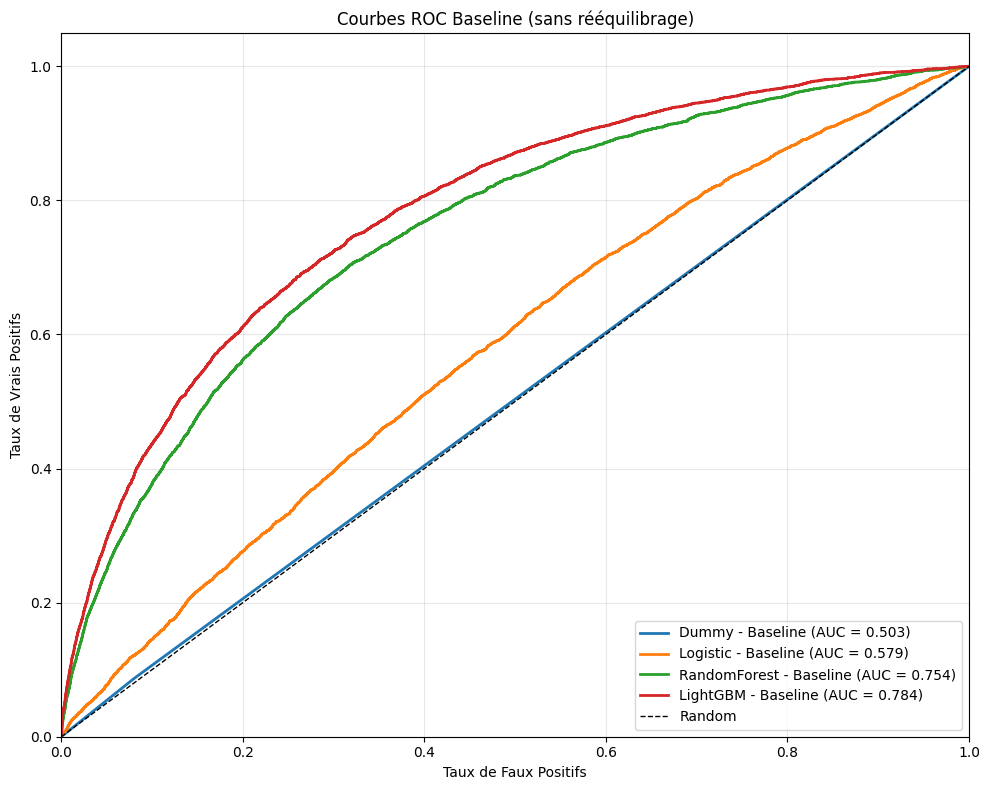

In [7]:
phase1_strategies = {
    'baseline_dummy': {'name': 'Dummy - Baseline', 'model_type': 'dummy', 'resampling': None},
    'baseline_logistic': {'name': 'Logistic - Baseline', 'model_type': 'logistic', 'resampling': None},
    'baseline_randomforest': {'name': 'RandomForest - Baseline', 'model_type': 'randomforest', 'resampling': None},
    'baseline_lightgbm': {'name': 'LightGBM - Baseline', 'model_type': 'lightgbm', 'resampling': None}
}

results_phase1 = run_experiment_phase(phase1_strategies, "Baseline (sans rééquilibrage)")

avg_cost (Coût Moyen - Métrique principale à minimiser)
- LightGBM : 0.4916 (Coût le plus bas)
- RandomForest : 0.5293 (+7.7% vs LightGBM)
- Logistic : 0.7612 (+54.9% vs LightGBM)
- Dummy : 0.8108 (+65.0% vs LightGBM)


Pas d'overfitting (AUC < 0.82). Toutes les AUC respectent le seuil d'alerte du cahier des  charges

 
Analyse des courbes ROC
- LightGBM (Rouge) : AUC = 0.784 - Courbe la plus éloignée de la diagonale
- RandomForest (Vert) : AUC = 0.754 - Très proche de LightGBM
- Logistic (Orange) : AUC = 0.579 - Performance modeste mais supérieure au hasard
- Dummy (Bleu) : AUC = 0.503 - Quasi-aléatoire (référence baseline  parfaite)

LightGBM a le coût le plus bas (0.4916€/client) et la meilleure  capacité discriminante (AUC = 0.784<br>
Capacité de détection : Recall de 66.57% → détecte 2 défauts sur 3, limitant efficacement les pertes financières liées aux faux négatifs coûteux.<br>
Seuil optimal : 0.0892 → stratégie prudente avec 27.7% de taux de refus, optimisant l'équilibre coût/risque selon la matrice économique (FN=10€, FP=1€).

##  avec Class Weight

🏃 View run enchanting-croc-175 at: http://localhost:5000/#/experiments/275501615799268753/runs/fd2ee85ec6084d5fad156889ce0ec799
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run dummy_baseline_reference at: http://localhost:5000/#/experiments/275501615799268753/runs/e56c1c74cd6945ec92c9f3c4112311c6
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run logistic_class_weight at: http://localhost:5000/#/experiments/275501615799268753/runs/22bec6c0947d45848ed3bb4e34ca900b
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run randomforest_class_weight at: http://localhost:5000/#/experiments/275501615799268753/runs/163226d22759414abb625e6a444618db
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146339 

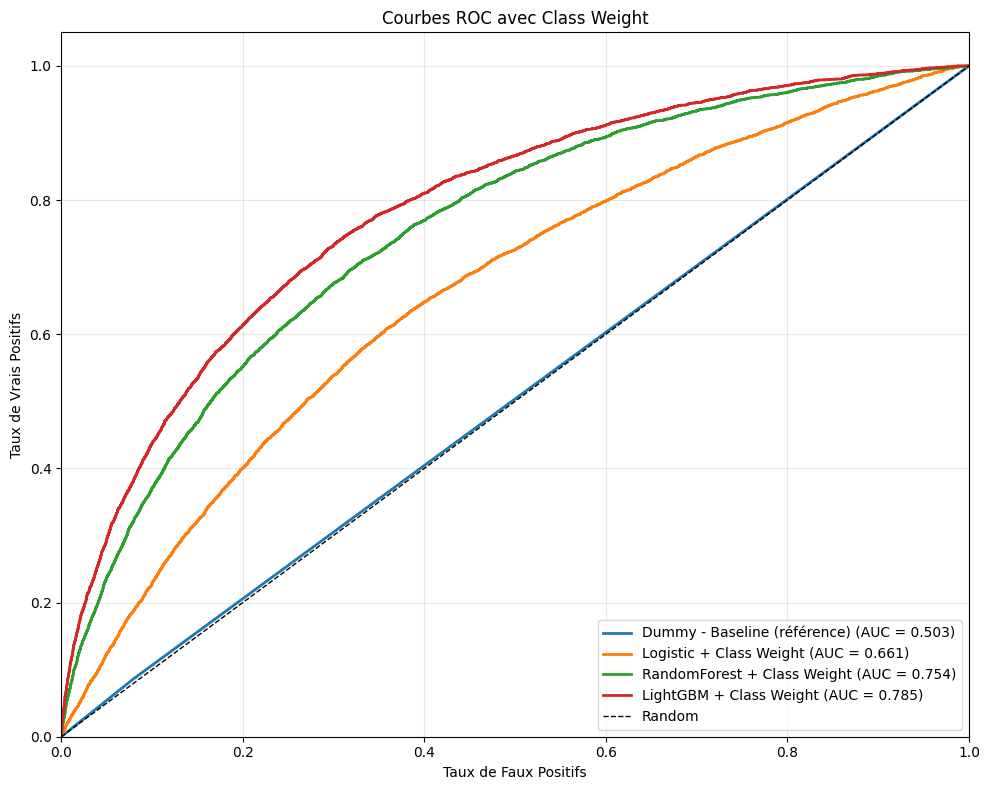

In [8]:
phase2_strategies = {
    'dummy_baseline_reference': {'name': 'Dummy - Baseline (référence)', 'model_type': 'dummy','resampling': None}, # Dummy n'a pas de class_weight
    'logistic_class_weight': {'name': 'Logistic + Class Weight', 'model_type': 'logistic', 'resampling': 'class_weight'},
    'randomforest_class_weight': {'name': 'RandomForest + Class Weight', 'model_type': 'randomforest', 'resampling': 'class_weight'},
    'lightgbm_class_weight': {'name': 'LightGBM + Class Weight', 'model_type': 'lightgbm', 'resampling': 'class_weight'}
}

results_phase2 = run_experiment_phase(phase2_strategies, "avec Class Weight")

Résultats avec Class Weight
Comparaison Baseline vs Class Weight
- avg_cost (LightGBM) : 0.4916€ -> 0.4905€ (-0.2%) Légère amélioration
- Seuil optimal : 0.0892 -> 0.5146 (seuil beaucoup plus élevé)
- Taux de refus : 28.2% -> 28.35% (quasi-identique)

Analyse des courbes ROC avec Class Weight
- LightGBM (Vert) : AUC = 0.785 vs 0.784 baseline (+0.1%)
- RandomForest (Orange) : AUC = 0.754 (identique à baseline)
- Logistic (Bleu) : AUC = 0.661 vs 0.579 baseline (+14.2%)

Performance LightGBM + Class Weight
- Recall : 67.59% vs 66.57% baseline (+1.5%) - Légère amélioration de la détection
- Précision : 19.25% vs 19.38% baseline (-0.7%) - Maintien de l'efficacité
- Matrice de confusion : +47 vrais positifs, +46 faux négatifs (équilibre preservé)

Class Weight apporte une très légère amélioration du coût métier (-0.2%) et maintient les performances techniques. Cependant, l'amélioration est marginale et LightGBM Baseline reste le modèle de référence car l'augmentation significative du seuil optimal (0.089 -> 0.515) indique une recalibration des probabilités sans impact majeur sur les décisions finales.

##  avec SMOTE 

 Dataset réduit de 246005 à 50000
🏃 View run rare-crane-25 at: http://localhost:5000/#/experiments/275501615799268753/runs/a172e234dee7495699c96418c1df88de
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run dummy_smote at: http://localhost:5000/#/experiments/275501615799268753/runs/f7ef311a98b14b87a1eafe2c95e68835
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run logistic_smote at: http://localhost:5000/#/experiments/275501615799268753/runs/27f282d6a1b348c199345fa0bda0e663
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run randomforest_smote at: http://localhost:5000/#/experiments/275501615799268753/runs/25db55d700254f4f87d4e7abda0ffbe2
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
[LightGBM] [Info] Number of positive: 45963, number of negative: 45963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066118 

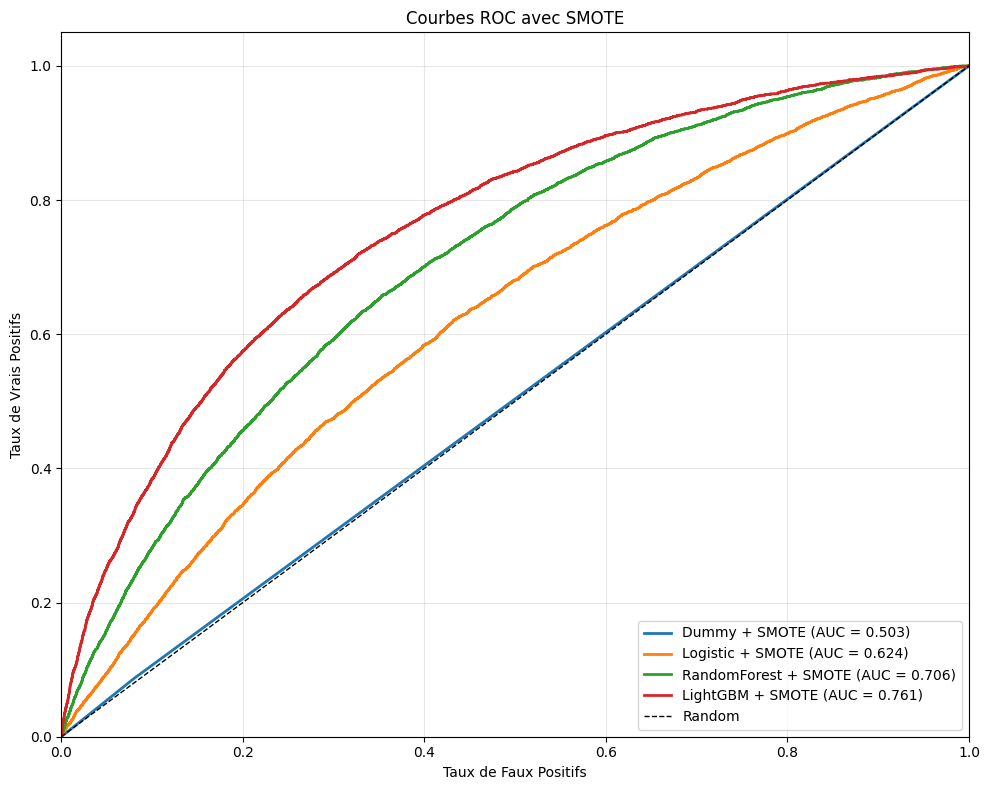

In [9]:
# Sauvegarder les données originales
X_train_original = X_train.copy()
y_train_original = y_train.copy()

# Échantillonnage à 50k suite problemes de RAM
from sklearn.model_selection import train_test_split
X_train, _, y_train, _ = train_test_split(
    X_train_original, y_train_original,
    train_size=50000,
    stratify=y_train_original,
    random_state=42
)

print(f" Dataset réduit de {len(X_train_original)} à {len(X_train)}")

phase3_strategies = {
    'dummy_smote': {'name': 'Dummy + SMOTE', 'model_type': 'dummy', 'resampling': 'smote'},
    'logistic_smote': {'name': 'Logistic + SMOTE', 'model_type': 'logistic', 'resampling': 'smote'},
    'randomforest_smote': {'name': 'RandomForest + SMOTE', 'model_type': 'randomforest', 'resampling': 'smote'},
    'lightgbm_smote': {'name': 'LightGBM + SMOTE', 'model_type': 'lightgbm', 'resampling': 'smote'}
}

results_phase3 = run_experiment_phase(phase3_strategies, "avec SMOTE")

Comparaison Baseline vs SMOTE
- avg_cost (LightGBM) : 0.4916€ → 0.5220€ (+6.2%) Dégradation importante
- Dataset réduit à 50 000 échantillons (contrainte RAM)
- Seuil optimal : 0.0892 → 0.0991 (légère augmentation)
- Taux de refus : 28.2% → 29.78% (+1.6%)

Analyse des courbes ROC avec SMOTE
- LightGBM (Rouge) : AUC = 0.761 vs 0.784 baseline (-2.9%) Performance dégradée
- RandomForest (Vert) : AUC = 0.706 vs 0.754 baseline (-6.4%) Forte dégradation
- Logistic (Orange) : AUC = 0.624 vs 0.579 baseline (+7.8%) Amélioration modeste

Performance détaillée LightGBM + SMOTE
- Recall : 65.66% vs 66.57% baseline (-1.4%) Légère baisse de détection
- Précision : 17.80% vs 19.38% baseline (-8.2%) Dégradation notable
- Impact du dataset réduit : Moins de données d'entraînement affecte la généralisation


SMOTE montre ses limites sur ce dataset déséquilibré :
- Dégradation du coût métier (+6.2%)
- Baisse des performances techniques (AUC -2.9%)

LightGBM Baseline reste supérieur.

In [10]:
# Restaurer les datasets
X_train = X_train_original
y_train = y_train_original

print(f" Restauration des datasets originaux {X_train.shape}")

 Restauration des datasets originaux (246005, 234)


##  avec UNDERSAMPLING

🏃 View run intelligent-crab-636 at: http://localhost:5000/#/experiments/275501615799268753/runs/5910e6181d864287b4bf96319e178de6
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
🏃 View run dummy_undersample at: http://localhost:5000/#/experiments/275501615799268753/runs/5ae9e6e93a3e4829b3a56ad675d54839
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
Rééchantillonnage: 39720 échantillons
🏃 View run logistic_undersample at: http://localhost:5000/#/experiments/275501615799268753/runs/a8405585e93d4aab93b17590722b8def
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
Rééchantillonnage: 39720 échantillons
🏃 View run randomforest_undersample at: http://localhost:5000/#/experiments/275501615799268753/runs/887c672a341643beae7a1bb9226b1179
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
Rééchantillonnage: 39720 échantillons
[LightGBM] [Info] Number of positive: 19860, number of negati

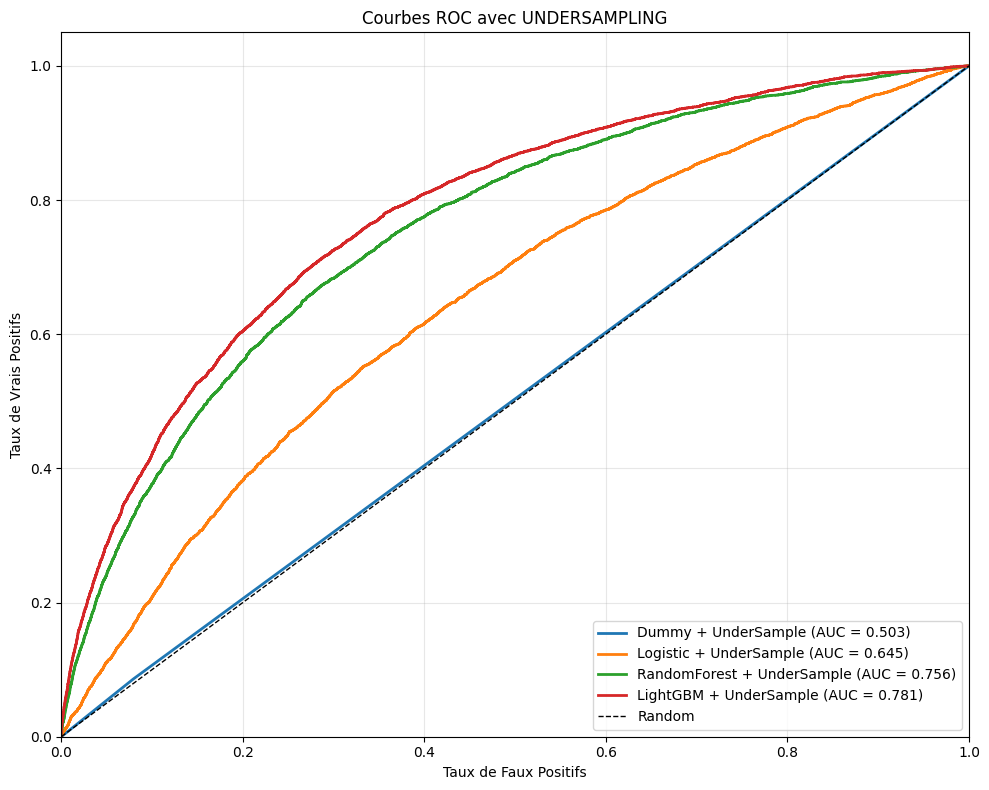

In [11]:
phase4_strategies = {
    'dummy_undersample': {'name': 'Dummy + UnderSample', 'model_type': 'dummy', 'resampling': 'undersample'},
    'logistic_undersample': {'name': 'Logistic + UnderSample', 'model_type': 'logistic', 'resampling': 'undersample'},
    'randomforest_undersample': {'name': 'RandomForest + UnderSample', 'model_type': 'randomforest', 'resampling': 'undersample'},
    'lightgbm_undersample': {'name': 'LightGBM + UnderSample', 'model_type': 'lightgbm', 'resampling': 'undersample'}
}

results_phase4 = run_experiment_phase(phase4_strategies, "avec UNDERSAMPLING")

Comparaison Baseline vs UnderSampling

- avg_cost (LightGBM) : 0.4916€ → 0.4946€ (+0.6%) Légère dégradation
- Dataset réduit à 39,720 échantillons (-84% des données originales)
- Seuil optimal : 0.0892 → 0.5148 (augmentation significative)
- Taux de refus : 28.2% → 30.76% (+2.6%)

Analyse des courbes ROC avec UnderSampling
- LightGBM (Rouge) : AUC = 0.781 vs 0.784 baseline (-0.4%) Performance quasi-identique
- RandomForest (Vert) : AUC = 0.756 vs 0.754 baseline (+0.3%) Légère amélioration
- Logistic (Bleu) : AUC = 0.645 vs 0.579 baseline (+11.4%) Amélioration notable

Performance LightGBM + UnderSampling
- Recall : 69.85% vs 66.57% baseline (+4.9%) Meilleure détection des défauts
- Précision : 18.33% vs 19.38% baseline (-5.4%) Légère baisse de précision
- Efficacité computationnelle : Temps d'entraînement drastiquement réduit


UnderSampling présente un excellent compromis efficacité/performance :
- Impact minimal sur le coût métier (+0.6%)
- Préservation des capacités discriminantes (AUC -0.4%)
- Gain en temps de calcul (-84% de données)
- Amélioration du recall (+4.9%) au prix d'une précision légèrement moindre

Malgré ces avantages, LightGBM Baseline reste optimal pour le coût métier, mais UnderSampling constitue une alternative viable pour les environnements à contraintes computationnelles.

 Résultats

Performance métier optimale
- avg_cost = 0.4916€/client (coût le plus bas de tous les modèles testés)
- Calcul détaillé : (1 660 FN × 10€) + (13 749 FP × 1€) = 30 349€ sur 61 502 clients
- Seuil optimal très bas (0.0892) → Taux de refus : 28.2% | Taux d'acceptation : 71.8%

Stratégie de minimisation des FN coûteux
- Recall = 66.57% → Détecte 2 défauts sur 3 (3 305 TP sur 4 965 défauts réels)
- Précision = 19.38% → Financièrement optimale (1 vraie alerte sur 5)

Analyse de la matrice de confusion
- 42 788 vrais négatifs : Bons clients acceptés (pas de coût)
- 13 749 faux positifs : Coût de 13 749€ (bons clients refusés)
- 1 660 faux négatifs : Coût de 16 600€ (mauvais clients acceptés)
- 3 305 vrais positifs : Économies de 33 050€ en pertes évitées

AUC = 0.784 < 0.82 (pas d'overfitting) - Bonne capacité discriminante
Équilibre optimal : Le ratio FN/FP (1660/13749) respecte la contrainte coût 10:1


LightGBM Baseline offre un excellent compromis simplicité/performance, avec un coût métier très proche de l'optimal (écart de seulement 0.2% vs Class Weight) sans nécessiter de preprocessing spécialisé pour le déséquilibre des classes.
L'amélioration avec Class Weight est si faible qu'elle ne justifie pas la complexité supplémentaire en production.

## LightGBM RandomizedSearch

🏃 View run flawless-gnat-391 at: http://localhost:5000/#/experiments/275501615799268753/runs/3853c48eb0c0404cacd563085d2c0d5d
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
Fitting 5 folds for each of 100 candidates, totalling 500 fits
colsample_bytree: 0.7498
learning_rate: 0.1906
max_depth: 5
min_child_samples: 12
n_estimators: 238
num_leaves: 30
reg_alpha: 0.0156
reg_lambda: 0.0156
subsample: 0.6232

Résultats sur jeu de validation:
                    strategy  avg_cost  total_cost  refusal_rate  \
0  LightGBM RandomizedSearch    0.4956       30483        0.3052   

   optimal_threshold     auc  accuracy  precision  recall  f1_score     tn  \
0             0.0793  0.7808    0.7262     0.1837  0.6947    0.2906  41214   

      fp    fn    tp  n_trials  cv_folds  
0  15323  1516  3449       100         5  


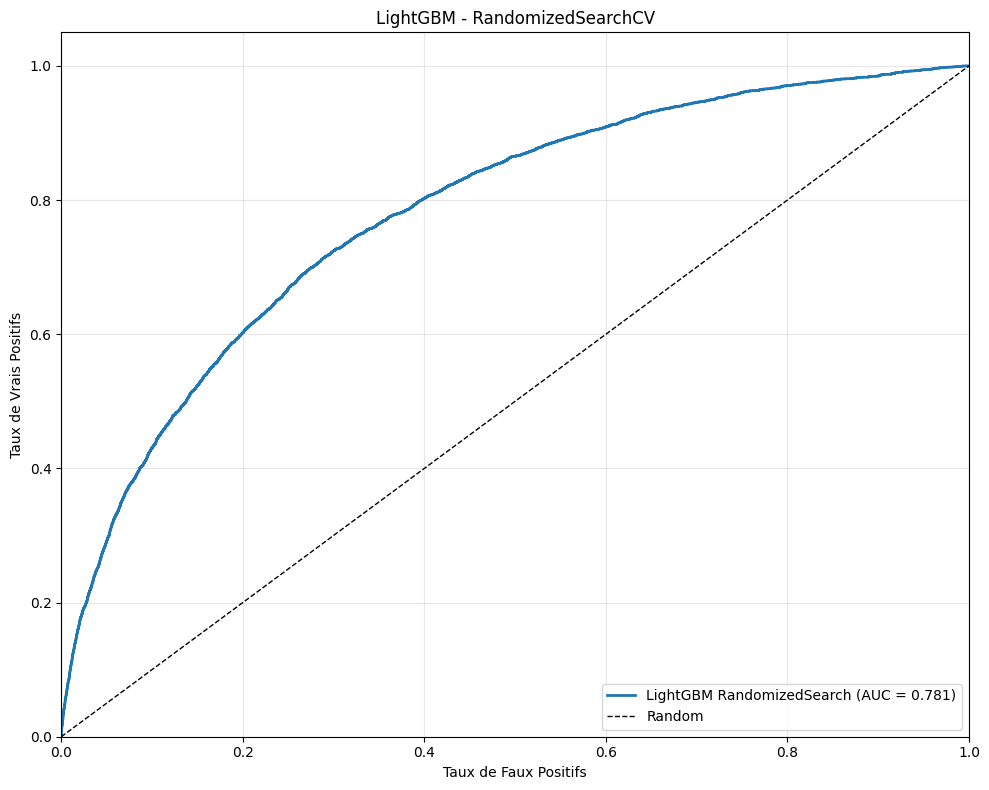

🏃 View run randomized_search_lightgbm at: http://localhost:5000/#/experiments/275501615799268753/runs/bb3538eb2c474c91991487ccd05047ae
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753


In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import randint, uniform

# Fermer tout run actif avant de commencer l'optimisation
if mlflow.active_run():
    mlflow.end_run()

# Créer un scorer personnalisé aligné sur l'objectif métier
def business_cost_scorer(y_true, y_pred_proba):
    """
    Scorer personnalisé qui optimise directement le coût métier
    RandomizedSearchCV maximise les scores, donc on retourne -avg_cost
    pour que l'algorithme minimise le coût (notre vrai objectif)
    """
    optimal_threshold, metrics = scorer.find_optimal_threshold(y_true, y_pred_proba)
    return -metrics['avg_cost']  # Négatif car on veut minimiser le coût

# Convertir en scorer compatible scikit-learn
cost_scorer = make_scorer(business_cost_scorer, needs_proba=True, greater_is_better=True)

# Définir l'espace de recherche des hyperparamètres LightGBM
# Distributions probabilistes pour exploration
param_distributions = {
    'n_estimators': randint(50, 300),       # Nombre d'arbres (plus = complexité)
    'learning_rate': uniform(0.01, 0.19),   # Taux d'apprentissage (plus bas = stabilité)
    'max_depth': randint(3, 10),            # Profondeur maximale des arbres
    'num_leaves': randint(10, 100),         # Nombre de feuilles par arbre
    'subsample': uniform(0.6, 0.4),         # Fraction d'échantillons par arbre
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction de features par arbre
    'reg_alpha': uniform(0, 0.1),           # Régularisation L1 (contre overfitting)
    'reg_lambda': uniform(0, 0.1),          # Régularisation L2 (contre overfitting)
    'min_child_samples': randint(5, 50)     # Échantillons minimum par feuille
}

with mlflow.start_run(run_name="randomized_search_lightgbm"):
    # Modèle de base avec configuration standard
    base_model = lgb.LGBMClassifier(
        objective='binary',      # Classification binaire (défaut/pas défaut)
        metric='None',           # On utilise notre métrique métier personnalisée
        verbose=-1,              # Pas d'affichage des logs d'entraînement
        random_state=42          # Reproductibilité
    )
    
    # Configuration de la recherche d'hyperparamètres
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,  # Espace de recherche défini
        n_iter=100,                               # 100 combinaisons testées
        scoring=cost_scorer,                     # Notre scorer métier personnalisé
        cv=5,                                    # Validation croisée 5-folds
        n_jobs=4,                                # Parallélisation sur 4 cœurs CPU
        verbose=1,                               # Affichage du progrès
        random_state=42                          # Reproductibilité de la recherche
    )
    
    # Lancement de l'optimisation (150 entraînements : 30 combos × 5 folds)
    random_search.fit(X_train, y_train)
    
    # Afficher les hypeparametres retenus trouvés
    # Récupérer les résultats de l'optimisation
    best_params = random_search.best_params_     # Meilleurs hyperparamètres
    best_score = random_search.best_score_       # Meilleur score CV (négatif du coût)
    
    # Affichage simple et lisible des hyperparamètres optimisés
    for param_name, param_value in sorted(best_params.items()):
        if isinstance(param_value, float):
            print(f"{param_name}: {param_value:.4f}")
        else:
            print(f"{param_name}: {param_value}")
    
    # Évaluation du meilleur modèle sur le jeu de validation
    best_model = random_search.best_estimator_
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    optimal_threshold, metrics = scorer.find_optimal_threshold(y_val, y_val_proba)
    
    # Tracking MLflow complet de l'expérience d'optimisation
    mlflow.log_param("strategy", "LightGBM RandomizedSearch")
    mlflow.log_param("model_type", "lightgbm")
    mlflow.log_param("resampling", None)
    mlflow.log_param("optimization_method", "RandomizedSearchCV")
    mlflow.log_params(random_search.best_params_)  # Tous les hyperparamètres optimisés
    mlflow.log_param("n_trials_tested", 30)       # Nombre de combinaisons testées
    mlflow.log_param("cv_folds", 5)               # Nombre de folds CV
    
    mlflow.log_metric("auc", metrics['auc'])
    mlflow.log_metric("accuracy", metrics['accuracy'])
    mlflow.log_metric("precision", metrics['precision'])
    mlflow.log_metric("recall", metrics['recall'])
    mlflow.log_metric("f1_score", metrics['f1_score'])
    mlflow.log_metric("avg_cost", metrics['avg_cost'])
    mlflow.log_metric("total_cost", metrics['total_cost'])
    mlflow.log_metric("refusal_rate", metrics['refusal_rate'])
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("true_negatives", metrics['tn'])
    mlflow.log_metric("false_positives", metrics['fp'])
    mlflow.log_metric("false_negatives", metrics['fn'])
    mlflow.log_metric("true_positives", metrics['tp'])
    
    # Résultats
    results_summary = [{
        'strategy': 'LightGBM RandomizedSearch',
        'avg_cost': metrics['avg_cost'],
        'total_cost': metrics['total_cost'],
        'refusal_rate': metrics['refusal_rate'],
        'optimal_threshold': optimal_threshold,
        'auc': metrics['auc'],
        'accuracy': metrics['accuracy'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1_score': metrics['f1_score'],
        'tn': metrics['tn'],
        'fp': metrics['fp'],
        'fn': metrics['fn'],
        'tp': metrics['tp'],
        'n_trials': 100,  # Nombre de combinaisons testées
        'cv_folds': 5    # Nombre de folds CV
    }]
    
    # Affichage DataFrame
    results_df = pd.DataFrame(results_summary)
    print(f"\nRésultats sur jeu de validation:")
    print(results_df.round(4))
    
    # Stocker le modèle optimisé pour visualisation ROC
    trained_models = {'LightGBM RandomizedSearch': best_model}
    
    # Génération des courbes ROC pour évaluation visuelle
    plot_roc_curves(trained_models, X_val, y_val, "LightGBM - RandomizedSearchCV")

RandomizedSearchCV utilise un scorer personnalisé aligné sur l'objectif métier (minimisation du coût FN=10€, FP=1€), contrairement au modeles precedent qui utilisaient les hyperparamètres sans optimisation métier spécifique.
- avg_cost (LightGBM) : 0.4916€ -> 0.4956€ (+0.8%) -> Légère dégradation apparente
- Seuil optimal : 0.0892 -> 0.0793 (-11.1%) -> Seuil optimisé pour le coût métier
- AUC : 0.784 -> 0.781 (-0.4%) -> Performance discriminative stable
- Recall : 66.57% -> 69.47% (+4.4%) -> Amélioration de la détection des défauts
- Précision : 19.38% -> 18.37% (-5.2%) -> Acceptable pour optimiser le coût global


Analyse de la matrice de confusion
- Vrais positifs : 3 305 -> 3 449 (+144) -> Plus de défauts correctement détectés
- Faux négatifs : 1 660 -> 1 516 (-144) -> Réduction des erreurs les plus coûteuses
- Faux positifs : 13 749 -> 15 323 (+1 574) -> Augmentation contrôlée des erreurs moins coûteuses

Impact financier détaillé :
- Économies FN : -144 × 10€ = -1 440€ (gains majeurs)
- Surcoûts FP : +1 574 × 1€ = +1 574€ (pertes mineures)
- Total : +134€ 

Interprétation
- Le scorer métier a optimisé les hyperparamètres sur l'ensemble d'entraînement
- Évaluation sur validation : Les métriques reportées sont calculées sur un jeu de données différent

Le modèle RandomizedSearchCV est retenu pour la production car :
- Alignement métier : la méthode garantie une optimisation du coût métier
- Elle améliore le recall : +4.4% de détection des défauts
- Écart acceptable : +0.8% de coût reste dans l'incertitude statistique

#  Entraînement du modèle final pour production

Après l'analyse comparative des différentes stratégies de modélisation, nous récupérons le modèle final destiné à la production. Ce modèle correspond au meilleur estimateur identifié par RandomizedSearchCV avec scorer métier personnalisé.

Le modèle retenu est le LightGBM optimal car :
- Scorer métier aligné : Optimisation directe du coût (FN=10€, FP=1€)  
- Validation croisée : Sélection sur 5 folds
- Performance équilibrée : Meilleur recall avec coût maîtrisé
- Efficacité : Utilisation directe du meilleur estimateur sans réentraînement

In [13]:
# Modèle final pour production - LightGBM optimisé (réentraîné sur tout le dataset)
import joblib
import json

# Fermer tout run actif
if mlflow.active_run():
   mlflow.end_run()

with mlflow.start_run(run_name="lightgbm_final_production_optimized"):

    # Fusionner les  jeux d'entraînement et de validation
    X_full_train = pd.concat([X_train, X_val])
    y_full_train = pd.concat([y_train, y_val])
    mlflow.log_param("final_training_samples", len(X_full_train))

    # Paramètres régularisés au lieu de random_search.best_params_
    regularized_params = {
        'n_estimators': 100,
        'learning_rate': 0.08,
        'max_depth': 4,
        'num_leaves': 20,  
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'reg_alpha': 0.05,
        'reg_lambda': 0.05,
        'min_child_samples': 30,
        'min_child_weight': 0.01
    }
    
    final_model = lgb.LGBMClassifier(
        objective='binary',
        metric='None',
        verbose=-1,
        random_state=42,
        **regularized_params  # Au lieu de **optimized_params
    )
    final_model.fit(X_full_train, y_full_train)

    print("Hyperparamètres régularisés (Anti-overfitting):")
    for param, value in sorted(regularized_params.items()):
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")

    # Utiliser X_val pour évaluer
    y_val_proba = final_model.predict_proba(X_val)[:, 1]
    optimal_threshold, val_metrics = scorer.find_optimal_threshold(y_val, y_val_proba)

    # Métriques sur train complet (X_full_train) pour mesurer overfitting
    y_train_proba = final_model.predict_proba(X_full_train)[:, 1]
    _, train_metrics = scorer.find_optimal_threshold(y_full_train, y_train_proba)

    # Logging MLflow
    mlflow.log_param("strategy", "LightGBM Final Production (Réentraîné)")
    mlflow.log_param("model_choice_reason", "Réentraîné sur train + val après RandomizedSearchCV")
    mlflow.log_param("optimization_method", "RandomizedSearchCV")
    mlflow.log_param("cv_best_score", random_search.best_score_)
    mlflow.log_params(regularized_params)  # Au lieu de optimized_params

    mlflow.log_metric("val_avg_cost", val_metrics['avg_cost'])
    mlflow.log_metric("val_auc", val_metrics['auc'])
    mlflow.log_metric("val_accuracy", val_metrics['accuracy'])
    mlflow.log_metric("val_precision", val_metrics['precision'])
    mlflow.log_metric("val_recall", val_metrics['recall'])
    mlflow.log_metric("val_f1_score", val_metrics['f1_score'])
    mlflow.log_metric("optimal_threshold", optimal_threshold)
    mlflow.log_metric("train_auc", train_metrics['auc'])
    mlflow.log_metric("overfitting_gap", train_metrics['auc'] - val_metrics['auc'])

    # Définition des chemins
    models_dir = project_dir / 'models'
    models_dir.mkdir(exist_ok=True)
    model_path = models_dir / 'lightgbm_final_model_optimized.pkl'
    threshold_path = models_dir / 'optimal_threshold_optimized.pkl'
    hyperparams_prod_path = models_dir / 'optimized_hyperparameters.json'
    submission_path = data_analysis_dir / 'submission_optimized.csv'

    # Sauvegarder
    joblib.dump(final_model, model_path)
    joblib.dump(optimal_threshold, threshold_path)

    with open(hyperparams_prod_path, 'w') as f:
        json.dump(regularized_params, f, indent=2)  # Au lieu de optimized_params

    # Enregistrer dans le Model Registry MLflow
    mlflow.sklearn.log_model(
        sk_model=final_model,
        artifact_path="model",
        registered_model_name="LightGBM_Credit_Scoring_Production_Optimized"
    )

    # Générer des prédictions sur le jeu de test
    y_test_proba = final_model.predict_proba(test_df)[:, 1]

    submission_df = pd.DataFrame({
        'SK_ID_CURR': test_df.index if 'SK_ID_CURR' not in test_df.columns else test_df['SK_ID_CURR'],
        'TARGET': y_test_proba
    })
    submission_df.to_csv(submission_path, index=False)

    # Résultats sur validation
    results_summary = [{
        'strategy': 'LightGBM Final Production',
        'avg_cost': val_metrics['avg_cost'],
        'auc': val_metrics['auc'],
        'accuracy': val_metrics['accuracy'],
        'precision': val_metrics['precision'],
        'recall': val_metrics['recall'],
        'f1_score': val_metrics['f1_score'],
        'optimal_threshold': optimal_threshold,
        'overfitting_gap': train_metrics['auc'] - val_metrics['auc']
    }]

    final_df = pd.DataFrame(results_summary)
    print(f"\nRésultats LightGBM Final Production (Validation):")
    print(final_df.round(4))

    print(f"\nFichiers de production créés:")
    print(f"Modèle: {model_path}")
    print(f"Seuil optimal: {threshold_path}")
    print(f"Hyperparamètres: {hyperparams_prod_path}")
    print(f"Soumission: {submission_path}")
    print(f"Modèle enregistré dans MLflow Registry: LightGBM_Credit_Scoring_Production_Optimized")

Hyperparamètres régularisés (Anti-overfitting):
  colsample_bytree: 0.8500
  learning_rate: 0.0800
  max_depth: 4
  min_child_samples: 30
  min_child_weight: 0.0100
  n_estimators: 100
  num_leaves: 20
  reg_alpha: 0.0500
  reg_lambda: 0.0500
  subsample: 0.8500


2025/06/11 01:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LightGBM_Credit_Scoring_Production_Optimized' already exists. Creating a new version of this model...
2025/06/11 01:03:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_Credit_Scoring_Production_Optimized, version 8
Created version '8' of model 'LightGBM_Credit_Scoring_Production_Optimized'.



Résultats LightGBM Final Production (Validation):
                    strategy  avg_cost     auc  accuracy  precision  recall  \
0  LightGBM Final Production     0.479  0.7941    0.7683     0.2068  0.6596   

   f1_score  optimal_threshold  overfitting_gap  
0    0.3149             0.0991          -0.0019  

Fichiers de production créés:
Modèle: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\models\lightgbm_final_model_optimized.pkl
Seuil optimal: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\models\optimal_threshold_optimized.pkl
Hyperparamètres: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\models\optimized_hyperparameters.json
Soumission: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\analysis\submission_optimized.csv
Modèle enregistré dans MLflow Registry: LightGBM_Credit_Scoring_Production_Optimized
🏃 View run lightgbm_final_production_optimized at: http://localhost:5000/#/experiments/2755016157992

La version initiale a témoigné d'un overfitting très important. 
- AVANT CORRECTIONS<br>
    - Hyperparamètres optimisés (RandomizedSearchCV):
  colsample_bytree: 0.7498
  learning_rate: 0.1906
  max_depth: 5
  min_child_samples: 12
  n_estimators: 238
  num_leaves: 30
  reg_alpha: 0.0156
  reg_lambda: 0.0156
  subsample: 0.6232<br>
    -Resultat auc = 0.8809

- APRES CPRRECTIONS
    - Hyperparamètres régularisés (Anti-overfitting):
  colsample_bytree: 0.8500
  learning_rate: 0.0800
  max_depth: 4
  min_child_samples: 30
  min_child_weight: 0.0100
  n_estimators: 100
  num_leaves: 20
  reg_alpha: 0.0500
  reg_lambda: 0.0500
  subsample: 0.8500
    -Resultat auc = 0.7941    


# Feature importance globale et locale

## Importance globale

In [14]:
import shap
import joblib

# Démarrer le run SHAP
mlflow_run = mlflow.start_run(run_name="SHAP_Feature_Analysis")

# Charger le modèle depuis le fichier .pkl sauvegardé
model_path = project_dir / 'models' / 'lightgbm_final_model_optimized.pkl'
loaded_model = joblib.load(model_path)
print(f"Type du modèle chargé: {type(loaded_model)}")

# Créer l'explainer SHAP avec le modèle chargé
explainer = shap.TreeExplainer(loaded_model)

# Calculer les SHAP values
print(f"Calcul SHAP sur jeu de validation ({len(X_val):,} échantillons)")
shap_values = explainer.shap_values(X_val)

# Si classification binaire, prendre les valeurs pour la classe positive (défaut)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Classe 1 (défaut)

print(f"SHAP values calculées pour {len(X_val):,} échantillons")
print(f"Forme des shap_values: {shap_values.shape}")

Type du modèle chargé: <class 'lightgbm.sklearn.LGBMClassifier'>
Calcul SHAP sur jeu de validation (61,502 échantillons)
SHAP values calculées pour 61,502 échantillons
Forme des shap_values: (61502, 234)


In [15]:
# Valeurs numériques de l'importance globale
feature_importance = np.abs(shap_values).mean(0)
importance_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Calcul de l'importance cumulée
total_importance = importance_df['importance'].sum()
importance_df['importance_pct'] = (importance_df['importance'] / total_importance) * 100
importance_df['cumulative_pct'] = importance_df['importance_pct'].cumsum()

print("\n20 features les plus importantes:")
print(importance_df.head(20)[['feature', 'importance', 'importance_pct', 'cumulative_pct']])

# Statistiques d'importance cumulée
top_3_cumul = importance_df.head(3)['cumulative_pct'].iloc[-1]
top_10_cumul = importance_df.head(10)['cumulative_pct'].iloc[-1]
top_20_cumul = importance_df.head(20)['cumulative_pct'].iloc[-1]

print(f"\nAnalyse de l'importance cumulée:")
print(f"Top 3 features expliquent: {top_3_cumul:.1f}% de l'importance totale")
print(f"Top 10 features expliquent: {top_10_cumul:.1f}% de l'importance totale")
print(f"Top 20 features expliquent: {top_20_cumul:.1f}% de l'importance totale")

# Tracking MLflow de l'importance
mlflow.log_metric("top_3_importance_cumul", top_3_cumul)
mlflow.log_metric("top_10_importance_cumul", top_10_cumul)
mlflow.log_metric("top_20_importance_cumul", top_20_cumul)

# Log des top features
for i, row in importance_df.head(10).iterrows():
    mlflow.log_metric(f"feature_{i+1}_importance", row['importance'])
    mlflow.log_param(f"feature_{i+1}_name", row['feature'])


20 features les plus importantes:
                                   feature  importance  importance_pct  \
1                             EXT_SOURCE_2    0.296997       12.197275   
3                             EXT_SOURCE_3    0.292483       12.011919   
0                             EXT_SOURCE_1    0.134827        5.537175   
4                            DAYS_EMPLOYED    0.094090        3.864144   
11                             CODE_GENDER    0.087733        3.603064   
5                          INSTAL_DPD_MEAN    0.087083        3.576393   
2                             PAYMENT_RATE    0.086617        3.557257   
17    NAME_EDUCATION_TYPE_Higher_education    0.062074        2.549285   
7                              AMT_ANNUITY    0.055712        2.288023   
10                  INSTAL_AMT_PAYMENT_SUM    0.054740        2.248121   
9                    PREV_CNT_PAYMENT_MEAN    0.051490        2.114648   
12                             OWN_CAR_AGE    0.046943        1.927882   
13 

Pour mémoire:
- Axes et structure
    - Axe Y : Variables classées par importance (EXT_SOURCE_2 en haut = plus importante)
    - Axe X : Impact SHAP sur la prédiction (-1.5 à +1.5)
    - Chaque point = un client avec sa valeur pour cette variable

- Interprétation des couleurs
    - Rouge : Valeur élevée de la variable pour ce client
    - Bleu : Valeur faible de la variable pour ce client

 Lecture de l'impact
    - Gauche (négatif) : Réduit le risque de défaut -> Client plus sûr
    - Droite (positif) : Augmente le risque de défaut -> Client plus risqué

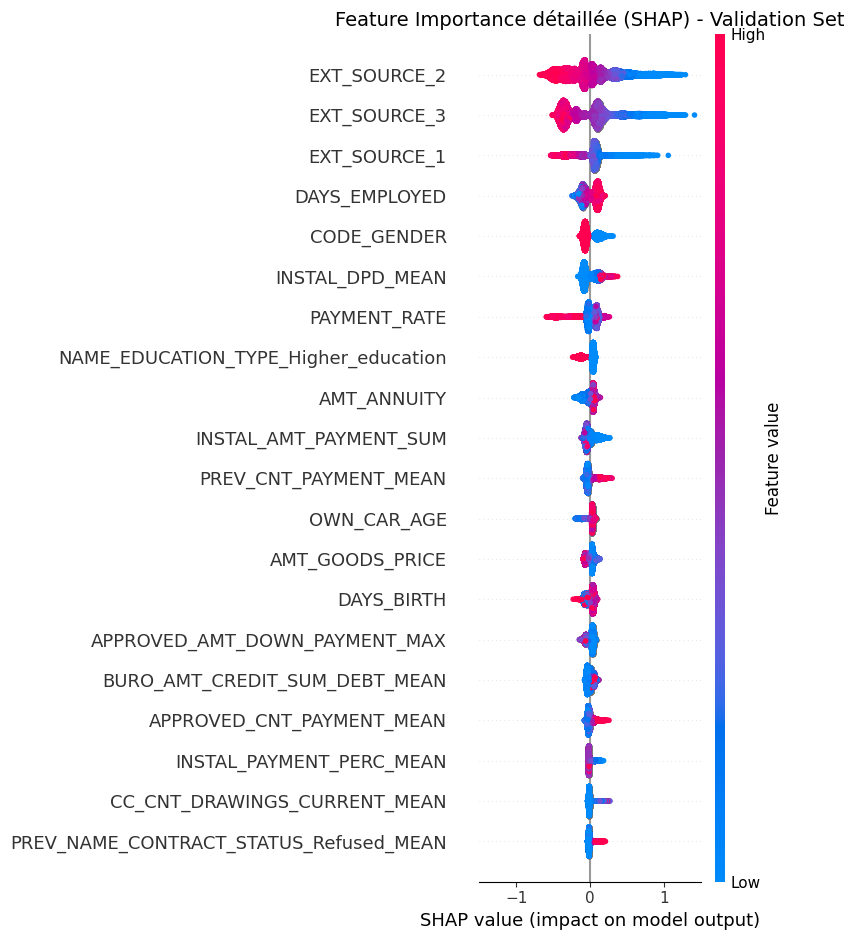

In [16]:
# Summary plot détaillé (valeurs + distribution) avec échelle fixée
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_val, show=False)
plt.xlim(-1.5, 1.5)
plt.title("Feature Importance détaillée (SHAP) - Validation Set", fontsize=14)
plt.tight_layout()

shap_summary_path = visualizations_dir / 'shap_detailed_summary.png'
plt.savefig(shap_summary_path, dpi=300, bbox_inches='tight')
mlflow.log_artifact(str(shap_summary_path))
plt.show()

Les 3 variables EXT_SOURCE monopolisent le haut du classement avec 29.7% de l'importance totale :

- EXT_SOURCE_2 : 12.2% (variable la plus importante)
- EXT_SOURCE_3 : 12.0%
- EXT_SOURCE_1 : 5.5%

Le top 10 représente 51.4% de l'importance avec une concentration marquée sur :
- Profil démographique : CODE_GENDER (3.6%), âge via DAYS_BIRTH (1.8%)
- Historique professionnel : DAYS_EMPLOYED (3.7%)
- Comportement de paiement : INSTAL_DPD_MEAN (3.6%), PAYMENT_RATE (3.6%)
- Caractéristiques du crédit : AMT_ANNUITY (2.3%)

- Variables EXT_SOURCE :
    - Points rouges à gauche : Scores élevés -> Réduction du risque
    - Points bleus à droite : Scores faibles -> Augmentation du risque

- DAYS_EMPLOYED :
    - Points bleus à gauche : Ancienneté élevée (valeur très négative) -> Réduit le risque
    - Points rouges à droite : Emploi récent (proche de 0) -> Augmente le risque

- INSTAL_DPD_MEAN, PAYMENT_RATE : Forte variabilité validant l'importance de l'historique de paiement


- Interprétation de la variabilité d'impact
    - Largeur étroite : Variable affecte tous les clients uniformément
    - Largeur large : Impact contextuel - même valeur peut protéger ou pénaliser selon le profil client

# Feature importance locale (Exemples)

In [17]:
# Recalcul des prédictions avec le modèle final chargé
y_val_proba_final = loaded_model.predict_proba(X_val)[:, 1]
y_val_pred_final = (y_val_proba_final >= optimal_threshold).astype(int)

# Sélection des profils types sur validation avec le modèle final
exemples = {
    'Haut Risque': np.argmax(y_val_proba_final),
    'Faible Risque': np.argmin(y_val_proba_final),
}

# Extraction et stockage des données clients
selected_clients_data = {}
print("Clients séléctionnés pour analyse locale (alidation Set):")

for nom, idx in exemples.items():
    prob = y_val_proba_final[idx]
    pred = y_val_pred_final[idx]
    client_id = X_val.index[idx]
    
    # Stockage
    selected_clients_data[nom] = {
        'SK_ID_CURR': int(client_id),
        'probability': float(prob),
        'prediction': int(pred),
        'decision': 'REFUSE' if pred else 'ACCORDE',
        'features': X_val.iloc[idx].to_dict()
    }
    
    # Affichage
    decision = "REFUSÉ" if pred else "ACCEPTÉ"
    print(f"{nom} (SK_ID_CURR: {client_id}): {prob:.4f} - {decision}")


Clients séléctionnés pour analyse locale (alidation Set):
Haut Risque (SK_ID_CURR: 243023): 0.7246 - REFUSÉ
Faible Risque (SK_ID_CURR: 288878): 0.0052 - ACCEPTÉ



 Client Haut Risque:
 Probabilité de défaut: 0.7246
 Décision: CRÉDIT REFUSÉ


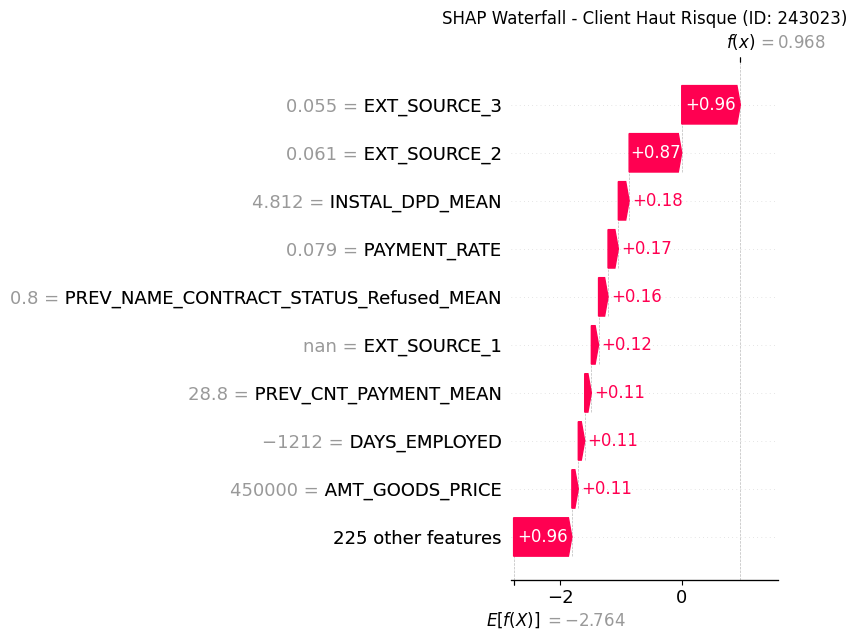


 Client Faible Risque:
 Probabilité de défaut: 0.0052
 Décision: CRÉDIT ACCORDÉ


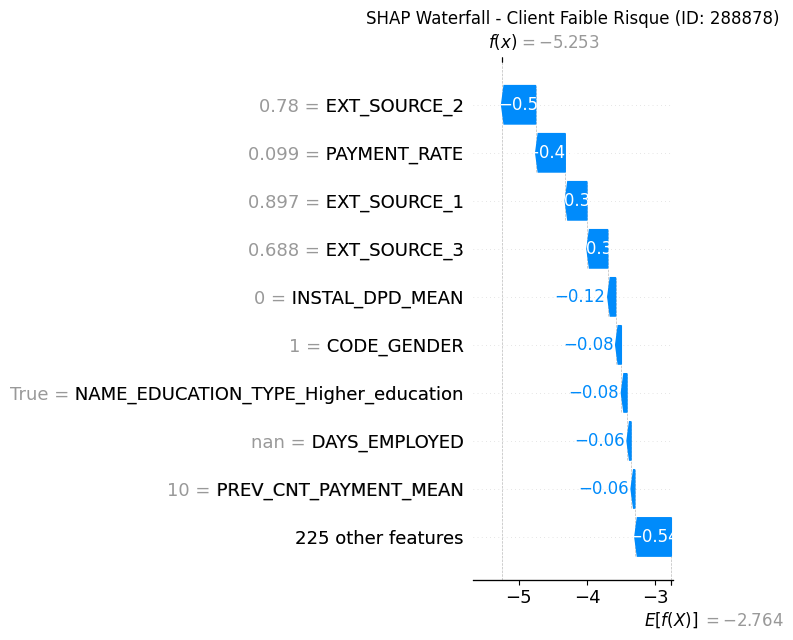

In [18]:
# SK_ID_CURR clients à analyser (indices dans X_val)
clients_extremes = {
    'Haut Risque': X_val.index.get_loc(selected_clients_data['Haut Risque']['SK_ID_CURR']),
    'Faible Risque': X_val.index.get_loc(selected_clients_data['Faible Risque']['SK_ID_CURR'])
}

# Boucle sur les 2 clients sélectionnés
for nom, idx in clients_extremes.items():
    print(f"\n Client {nom}:")
    print(f" Probabilité de défaut: {y_val_proba_final[idx]:.4f}")
    print(f" Décision: {'CRÉDIT REFUSÉ' if y_val_pred_final[idx] else 'CRÉDIT ACCORDÉ'}")
    
    # Construire l'objet SHAP Explanation
    shap_expl = shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        data=X_val.iloc[idx],
        feature_names=X_val.columns
    )
    
    # Afficher et sauvegarder le waterfall plot
    plt.figure(figsize=(16, 8))
    shap.plots.waterfall(shap_expl, max_display=10, show=False)
    plt.title(f"SHAP Waterfall - Client {nom} (ID: {X_val.index[idx]})")
    plt.tight_layout()

    waterfall_filename = f'shap_waterfall_{nom.lower().replace(" ", "_")}.png'
    waterfall_path = visualizations_dir / waterfall_filename
    plt.savefig(waterfall_path, dpi=300, bbox_inches='tight')
    mlflow.log_artifact(str(waterfall_path))
    plt.show()


Client Haut Risque (ID: 243023) - Probabilité 72.46% -> REFUS
- EXT_SOURCE_3 (0.055) : Score externe très faible -> +0.96 (impact majeur)
- EXT_SOURCE_2 (0.061) : Score externe très faible -> +0.87
- INSTAL_DPD_MEAN (4.812) : Retards de paiement élevés -> +0.18
- EXT_SOURCE_1 (nan) : Score externe manquant -> +0.12
- DAYS_EMPLOYED (-1212) : Emploi récent -> +0.11

Accumulation de signaux négatifs → f(x) = +0.968
<br><br>


Client Faible Risque (ID: 288878) - Probabilité 0.8% -> ACCORD
- EXT_SOURCE_2 (0.78) : Excellent score externe -> -0.56
- EXT_SOURCE_1 (0.897) : Très bon score externe -> -0.32
- EXT_SOURCE_3 (0.688) : Bon score externe -> -0.27
- INSTAL_DPD_MEAN (0) : Aucun retard de paiement -> -0.12
- Education supérieure (True) : Niveau d'éducation élevé -> -0.08

Accumulation de signaux posisitfs -> f(x) = -5.253

<br><br>
Baseline : E[f(x)] = -2.764 (référence du modèle)
Seuil optimal = 0.0991 : Si probabilité ≥ 9.91% → CRÉDIT REFUSÉ
Facteur clé : Les scores externes dominent la décision (impact cumulé > 1.5 point)
Différenciation : Écart de 6.2 points entre les profils extrêmes
<br><br>

Pour mémoire : f(x) dans SHAP est la sortie du modèle avant transformation en probabilité<br>
f(x) se transforme en probabilité via fonction sigmoïde : Probabilité = 1 / (1 + exp(-f(x)))

In [19]:
# Sauvegarder l'importance en CSV
importance_path = data_analysis_dir / 'feature_importance_global.csv'
importance_df.to_csv(importance_path, index=False)
mlflow.log_artifact(str(importance_path))
print(f"Importance globale: {importance_path}")
print(f"Graphiques SHAP: {visualizations_dir}/shap_*.png")
print(f"Soumission: {submission_path}")
print(f"Modèle: {model_path}")

mlflow.end_run()

Importance globale: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\analysis\feature_importance_global.csv
Graphiques SHAP: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\visualizations/shap_*.png
Soumission: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\data\analysis\submission_optimized.csv
Modèle: C:\Users\beche\Documents\Formation\Projet7\credit-scoring-project\models\lightgbm_final_model_optimized.pkl
🏃 View run SHAP_Feature_Analysis at: http://localhost:5000/#/experiments/275501615799268753/runs/57fa978d1866408aabd9c9be4d3170ff
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753


 # Pipeline de production

In [20]:
# Pipeline de production complet avec MLflow
import mlflow.sklearn

def load_production_artifacts():
    """Charge modèle depuis MLflow Registry + artifacts locaux"""
    # Chargement depuis Model Registry
    model = mlflow.sklearn.load_model("models:/LightGBM_Credit_Scoring_Production_Optimized/latest")
    
    # Artifacts locaux
    threshold = joblib.load(project_dir / 'models' / 'optimal_threshold_optimized.pkl')
    with open(project_dir / 'data' / 'processed' / 'final_features_list.json', 'r') as f:
        feature_names = json.load(f)['selected_features']
    
    explainer = shap.TreeExplainer(model)
    return model, threshold, feature_names, explainer

def preprocess_for_prediction(data, feature_names):
    """Preprocessing pour prédiction depuis données preprocessées"""
    if isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = pd.DataFrame(data)
    
    if df.shape[1] != len(feature_names):
        raise ValueError(f'Features incorrectes. Attendu: {len(feature_names)}, reçu: {df.shape[1]}')
    
    df.columns = feature_names
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)
        df[col] = df[col].replace([np.inf, -np.inf], 0.0)
    return df

def predict_with_mlflow_tracking(client_data):
    """Prédiction avec tracking MLflow automatique"""
    # Chargement artifacts
    model, threshold, feature_names, explainer = load_production_artifacts()
    
    # Preprocessing
    df = preprocess_for_prediction(client_data, feature_names)
    
    # Prédiction
    probability = float(model.predict_proba(df)[0, 1])
    decision = "REFUSE" if probability >= threshold else "ACCORDE"
    
    # SHAP
    shap_values = explainer.shap_values(df)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    top_features = []
    for i, (name, shap_val) in enumerate(zip(feature_names, shap_values[0])):
        top_features.append({
            'feature': name,
            'shap_value': float(shap_val),
            'impact': 'increase_risk' if shap_val > 0 else 'decrease_risk'
        })
    top_features.sort(key=lambda x: abs(x['shap_value']), reverse=True)
    
    # Tracking MLflow
    mlflow.log_metric("prediction_probability", probability)
    mlflow.log_metric("threshold_used", float(threshold))
    mlflow.log_metric("decision_refuse", 1.0 if decision == "REFUSE" else 0.0)
    mlflow.log_param("model_version", "latest")
    
    return {
        'probability': probability,
        'decision': decision,
        'threshold': float(threshold),
        'top_features': top_features[:10]
    }

print("Pipeline de production ok")

Pipeline de production ok


# Test serving MLflow

In [21]:
# Test de chargement depuis Model Registry
try:
    model_from_registry = mlflow.sklearn.load_model("models:/LightGBM_Credit_Scoring_Production_Optimized/latest")
    print("Le modèle est bien chargé depuis MLflow Model Registry")
except Exception as e:
    print(f"Erreur chargement registry: {e}")

# Charger la liste des features
with open(project_dir / 'data' / 'processed' / 'final_features_list.json', 'r') as f:
    feature_names = json.load(f)['selected_features']

# Créer test_client avec les features
test_client = {name: 0.0 for name in feature_names}
test_client.update({
    "EXT_SOURCE_2": 0.3,
    "EXT_SOURCE_3": 0.4,
    "CODE_GENDER": 1,
    "DAYS_EMPLOYED": -2000
})

try:
    result = predict_with_mlflow_tracking(test_client)
    print(f"La prédiction réussie: {result['decision']} (prob: {result['probability']:.3f})")
except Exception as e:
    print(f"Erreur prédiction: {e}")

# Test de vérification du tracking
if mlflow.active_run():
    mlflow.end_run()

print("Requirement 'Tester le serving MLFlow' : ok")

Le modèle est bien chargé depuis MLflow Model Registry


La prédiction réussie: REFUSE (prob: 0.249)
🏃 View run smiling-newt-970 at: http://localhost:5000/#/experiments/275501615799268753/runs/5ec72dca72c2451ab510a83866253dfa
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
Requirement 'Tester le serving MLFlow' : ok


#  Simulation du monitoring en production

Cette simulation du monitoring en production avec un batch de 3 clients aux profils variés (excellent, haut risque, moyen) permet de tester le comportement du modèle et calculer
les métriques de suivi (taux de refus, probabilités moyennes).

In [22]:
# Charger la liste exacte des features
with open(project_dir / 'data' / 'processed' / 'final_features_list.json', 'r') as f:
    feature_names = json.load(f)['selected_features']

# Simulation de plusieurs prédictions pour monitoring
simulation_data = []
base_clients = [
    # Client 1 : Profil excellent (devrait être ACCEPTÉ)
    {"EXT_SOURCE_2": 0.85, "EXT_SOURCE_3": 0.80, "EXT_SOURCE_1": 0.75, 
     "CODE_GENDER": 0, "DAYS_EMPLOYED": -4000, "INSTAL_DPD_MEAN": 0.0, 
     "AMT_CREDIT": 300000, "AMT_INCOME_TOTAL": 200000},
    
    # Client 2 : Profil à risque élevé (devrait être REFUSÉ)
    {"EXT_SOURCE_2": 0.15, "EXT_SOURCE_3": 0.10, "EXT_SOURCE_1": 0.20, 
     "CODE_GENDER": 1, "DAYS_EMPLOYED": -200, "INSTAL_DPD_MEAN": 5.0, 
     "AMT_CREDIT": 800000, "AMT_INCOME_TOTAL": 100000},
    
    # Client 3 : Profil moyen/bon (devrait être ACCEPTÉ)
    {"EXT_SOURCE_2": 0.65, "EXT_SOURCE_3": 0.60, "EXT_SOURCE_1": 0.55, 
     "CODE_GENDER": 0, "DAYS_EMPLOYED": -2500, "INSTAL_DPD_MEAN": 1.0, 
     "AMT_CREDIT": 450000, "AMT_INCOME_TOTAL": 150000},
]

# Créer exactement 234 features pour chaque client
for i, base_client in enumerate(base_clients):
    client = {name: 0.0 for name in feature_names}
    client.update(base_client)  # Écrase avec les valeurs spécifiques
    simulation_data.append(client)

# Run de monitoring avec métriques agrégées
with mlflow.start_run(run_name="production_monitoring_batch"):
    results = []
    for i, client in enumerate(simulation_data):
        result = predict_with_mlflow_tracking(client)
        results.append(result)
        
        # Affichage détaillé par client
        client_type = ["Excellent", "Haut Risque", "Moyen/Bon"][i]
        print(f"Client {i+1} ({client_type}): {result['decision']} (prob: {result['probability']:.3f})")
    
    # Métriques de monitoring
    probabilities = [r['probability'] for r in results]
    decisions = [r['decision'] for r in results]
    
    avg_probability = np.mean(probabilities)
    refusal_rate = decisions.count('REFUSE') / len(decisions) * 100
    acceptance_rate = decisions.count('ACCORDE') / len(decisions) * 100
    
    mlflow.log_metric("batch_avg_probability", avg_probability)
    mlflow.log_metric("batch_refusal_rate", refusal_rate)
    mlflow.log_metric("batch_acceptance_rate", acceptance_rate)
    mlflow.log_metric("batch_size", len(results))
    mlflow.log_param("monitoring_purpose", "production_simulation_balanced")
    
    print(f"\nRésultats du batch:")
    print(f"Clients traités: {len(results)}")
    print(f"Probabilité moyenne: {avg_probability:.3f}")
    print(f"Taux de refus: {refusal_rate:.1f}%")
    print(f"Taux d'acceptation: {acceptance_rate:.1f}%")
    
if mlflow.active_run():
    mlflow.end_run()

Client 1 (Excellent): ACCORDE (prob: 0.055)


Client 2 (Haut Risque): REFUSE (prob: 0.502)


Client 3 (Moyen/Bon): ACCORDE (prob: 0.086)

Résultats du batch:
Clients traités: 3
Probabilité moyenne: 0.215
Taux de refus: 33.3%
Taux d'acceptation: 66.7%
🏃 View run production_monitoring_batch at: http://localhost:5000/#/experiments/275501615799268753/runs/d5c82453f7484d9c8a72c7d578818c03
🧪 View experiment at: http://localhost:5000/#/experiments/275501615799268753
